In [3]:
from brian2 import *
import matplotlib.pyplot as plt

In [4]:
start_scope()

taum = 20*ms
taue = 5*ms
taui = 10*ms
tau_g = 50*ms
Vt = -50*mV
Vr = -60*mV
El = -60*mV
gi_t = -20*mV
factor=1*mV

# NOTE THE Z VARIABLE SEEMS TO BE INVERSED -- IT'S GOING TO ZERO WITH NO
# INH. ACTIIVTY AND GOING TOWARDS 1 WITH HIGH INH. ACTIVITY

eqs = '''
dv/dt  = (ge + z * gi - (v-El))/taum : volt (unless refractory)

dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt

#gi_z = z * gi : volt
dz/dt = 1/tau_g * (z_inf - z) : 1
z_inf = 1/(1 + exp(-2*10*gi_diff)) : 1
gi_diff = (gi_t - gi)/factor : 1
'''

# the goal is to try model a process whereby the failure of inhibition occurs
# taking inspiration from Liou et al., this can be achieved by relating the reversal potential for Inh. to the Exc. neuron's chloride gradient according to the Nernst equation for E_Cl (chloride)
# Liou also presents a generalized model of exhaustible inhibition where a factor z is modelled using first order kinetics and the Heaviside step function
# you're going to need to test this independently to make sure that it does work as expected -- i.e. more Inh --> lower Inh effectiveness


P = NeuronGroup(20, eqs, threshold='v>Vt', reset='v = Vr', refractory=1*ms,
                method='euler')
Pi = P[:10]
Pe = P[10:]

# initialization
P.v = 'Vr + rand() * (Vt - Vr)'
# P.v = 'Vr'
P.ge = 0*mV
P.gi = 0*mV
P.z  = 1

# make synaptic connections and specify the synaptic model
we = 1.62*mV # excitatory synaptic weight (voltage)  (this is equal to [E_exc = 0mV - V_rest = -60mV] * g_exc = 0.27nS
wi = -10*mV # inhibitory synaptic weight
Ce = Synapses(Pe, P, on_pre='ge+=we')
Ci = Synapses(Pi, Pe, on_pre='gi+=wi')
Ce.connect(p=0.2)
Ci.connect(p = 0.8)

# add a time varying input that increases in strength of firing for a short period of time


# poisson inputs into I neurons
wx = 50.0*mV  # excitatory input neurons
X = PoissonGroup(1, rates=20. * Hz)
X_2 = PoissonGroup(1, rates=20. * Hz)
CiX = Synapses(X, Pi, on_pre='ge+=wx')
CeX = Synapses(X_2, Pe, on_pre='ge+=wx')
CiX.connect(p=1.0)
CeX.connect(p=1.0)

trace = StateMonitor(P, 'v', record=[0,1,11,15])
trace_z = StateMonitor(P, 'z', record=[0,1,11, 15])
trace_gi_diff = StateMonitor(P, 'gi_diff', record=[0,1,11, 15])
s_mon = SpikeMonitor(P)
x_mon = SpikeMonitor(X)


run(5 * second, report='text')

Starting simulation at t=0. s for a duration of 5. s
5. s (100%) simulated in 5s


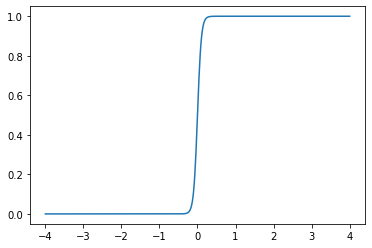

In [7]:
# exhaustible inhibition based on recent level of inhibitory input
gi_diff = np.linspace(-4, 4, 500)
# y = (3 * (np.exp(-(x/2)) - np.exp(-(x/3))))
# gi_diff = 20
y = 1/(1 + np.exp(-2*10*gi_diff))
plt.plot(gi_diff, y)
plt.show()


In [1]:
location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sNeuronalModelling/brian2_recurrent-net_seizures/' % location)

from brian_general_inhibition_exhaust import *

In [ ]:
net, trace, s_mon, trace_z, trace_gi, x_mon, trace_gi_diff = build_network()

net.run(5 * second, report='text')

Starting simulation at t=0. s for a duration of 5. s


In [ ]:
plt.figure(figsize=[20,3])
# plot(trace.t/ms, trace[10].v/mV)
plot(trace.t/ms, trace[11].v/mV)
# plt.plot(trace.t/ms, trace[100].v/mV)
xlabel('t (ms)')
ylabel('mV')
show()

plt.figure(figsize=[20,3])
plt.plot(s_mon.t/ms, s_mon.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.ylim(0,20)
plt.show()

In [ ]:
plt.figure(figsize=[20,3])
plot(trace_z.t/ms, trace_z[11].z)
xlabel('t (ms)')
ylabel('z')
show()

plt.figure(figsize=[20,3])
plot(trace_gi_diff.t/ms, trace_gi_diff[11].gi_diff)
xlabel('t (ms)')
ylabel('gi_diff')
show()